#**DQN autonomous ship path planning**#

#**My own gridworld environment**#

#**Generate valid data**#

#**Env Setup(gym)**#

In [0]:
!pip install gym-minigrid

In [0]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gym_minigrid
from gym.spaces import Tuple, Box, Discrete, MultiDiscrete, MultiBinary, Dict


#**Use Cuda**#

In [0]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

I am trying to use a package from gym, which perfectly satisfies my needs. However, if that's not easy to use, I would prefer to used my own environment, after acknowledging everything that I need to provide.

In [0]:
env_id ="MiniGrid-Dynamic-Obstacles-6x6-v0"
env = gym.make(env_id)

# number of input channel, I am trying to parse that myself since the third party package has no env.observation_space.shape attributes,
# which is used in the code provided by github
channel_value = env.observation_space.spaces
input_shape, num_actions = env.observation_space.spaces['image'].shape, env.action_space.n
input_shape=(input_shape[2],input_shape[0],input_shape[1])

#model = CnnDQN(input_shape,num_actions)

current_model = CnnDQN(input_shape,num_actions)
target_model  = CnnDQN(input_shape,num_actions)


#**CNNDQN**#

In [0]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):

        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        #print(input_shape)
        self.num_actions = num_actions
        #originially we have box(3,n,n) representing the RGB graph, so the #channel=input_shape[0]=3
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 8, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2, stride=1),
            nn.ReLU(),
        )
        #print(self.feature_size())
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 64),
            nn.ReLU(),
            nn.Linear(64, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = (torch.FloatTensor(np.float32(state)).unsqueeze(0))
            with torch.no_grad():
              q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

Replay Buffer

In [0]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        #test
        """
        res_1 = None
        try:
          res_1 = np.concatenate(state)
        except:
          print(state)
          return False
        """
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

Compute Temporal Difference Loss

In [0]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

Plot

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

Define Optimizer and Replay Buffer

In [0]:
 
if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

update_target(current_model, target_model)

Define epsilon

In [0]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

Reshape the State, the state is (7,7,3), while we need it to be (3(channels),7(w),7(h)), otherwise there will be problem within training process.

In [0]:
def reshape(width,height,state,color=3):
  #state used to be(w,h,c), reshape it to be(c,w,h)
  new_state = []
  for c in range(color):
    new_state_c = []
    for w in range(width):
      new_state_w = []
      for h in range(height):
        new_state_w.append(state[w][h][c])
      new_state_c.append(new_state_w)
    new_state.append(new_state_c)
  return new_state

def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

Training by CnnDQN\
need to revise the shape of state

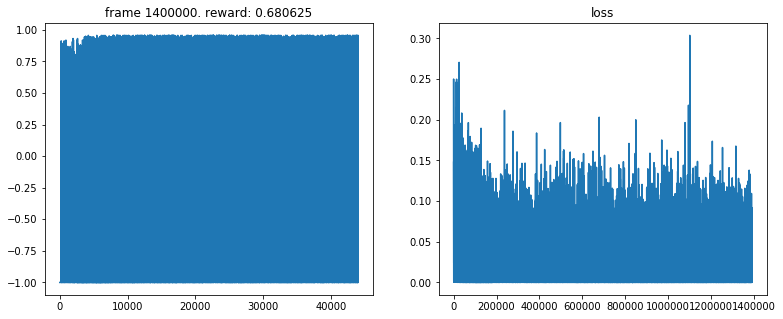

In [0]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()['image']
state = reshape(7,7,state)
for frame_idx in range(1, num_frames + 1):

    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)

    
    next_state, reward, done, _ = env.step(action)

    #parse the state
    next_state = next_state['image']
    next_state = reshape(7,7,next_state)

    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    if done:
        state = env.reset()['image']
        state = reshape(7,7,state)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data.item())
        
    if frame_idx % 10000 == 0:
        print(frame_idx)
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)

# That algorithm is more robust as the reward become stable as if the #of frame is over 340000

## 8*8

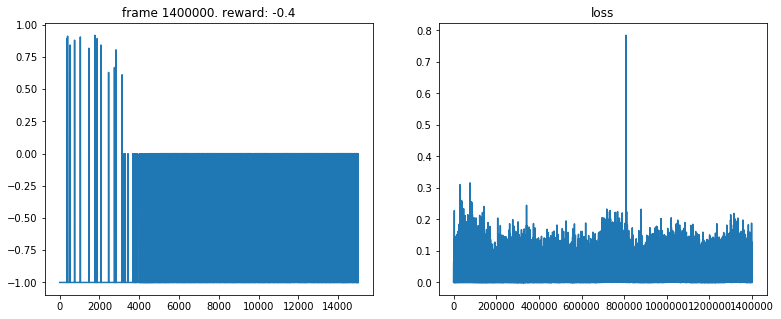

In [0]:
env_id_8 ="MiniGrid-Dynamic-Obstacles-8x8-v0"
env = gym.make(env_id_8)

# number of input channel, I am trying to parse that myself since the third party package has no env.observation_space.shape attributes,
# which is used in the code provided by github
channel_value = env_8.observation_space.spaces

input_shape, num_actions = env_8.observation_space.spaces['image'].shape, env_8.action_space.n
input_shape=(input_shape[2],input_shape[0],input_shape[1])

current_model = CnnDQN(input_shape,num_actions)
target_model  = CnnDQN(input_shape,num_actions)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)


num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()['image']
state = reshape(7,7,state)
for frame_idx in range(1, num_frames + 1):

    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)

    
    next_state, reward, done, _ = env.step(action)

    #parse the state
    next_state = next_state['image']
    next_state = reshape(7,7,next_state)

    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    if done:
        state = env.reset()['image']
        state = reshape(7,7,state)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data.item())
        
    if frame_idx % 10000 == 0:
        print(frame_idx)
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)